# Step 8: Neuron-wise Spike Time Shift — SHD Dataset

## Objective:
To distinguish whether the model relies more on **inter-neuron spike coordination** or **intra-neuron temporal structure**.

- For each sample and each neuron:
  - Randomly generate a shift value \( d \in [-D, D] \) (e.g., D = 5);
  - Shift **all spike times** of that neuron by \( d \);
- Each neuron's shift \( d \) is different **per trial**, but the spike intervals **within the neuron** remain unchanged.

## Rationale:
- This preserves the **internal rhythm** of each neuron;
- But it **destroys temporal alignment** across neurons;
- If the model relies heavily on inter-neuron synchronization, performance will degrade significantly;
- If it mainly focuses on individual neuron timing patterns, the impact will be minor.


In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Begin Here to Train the norm dataset

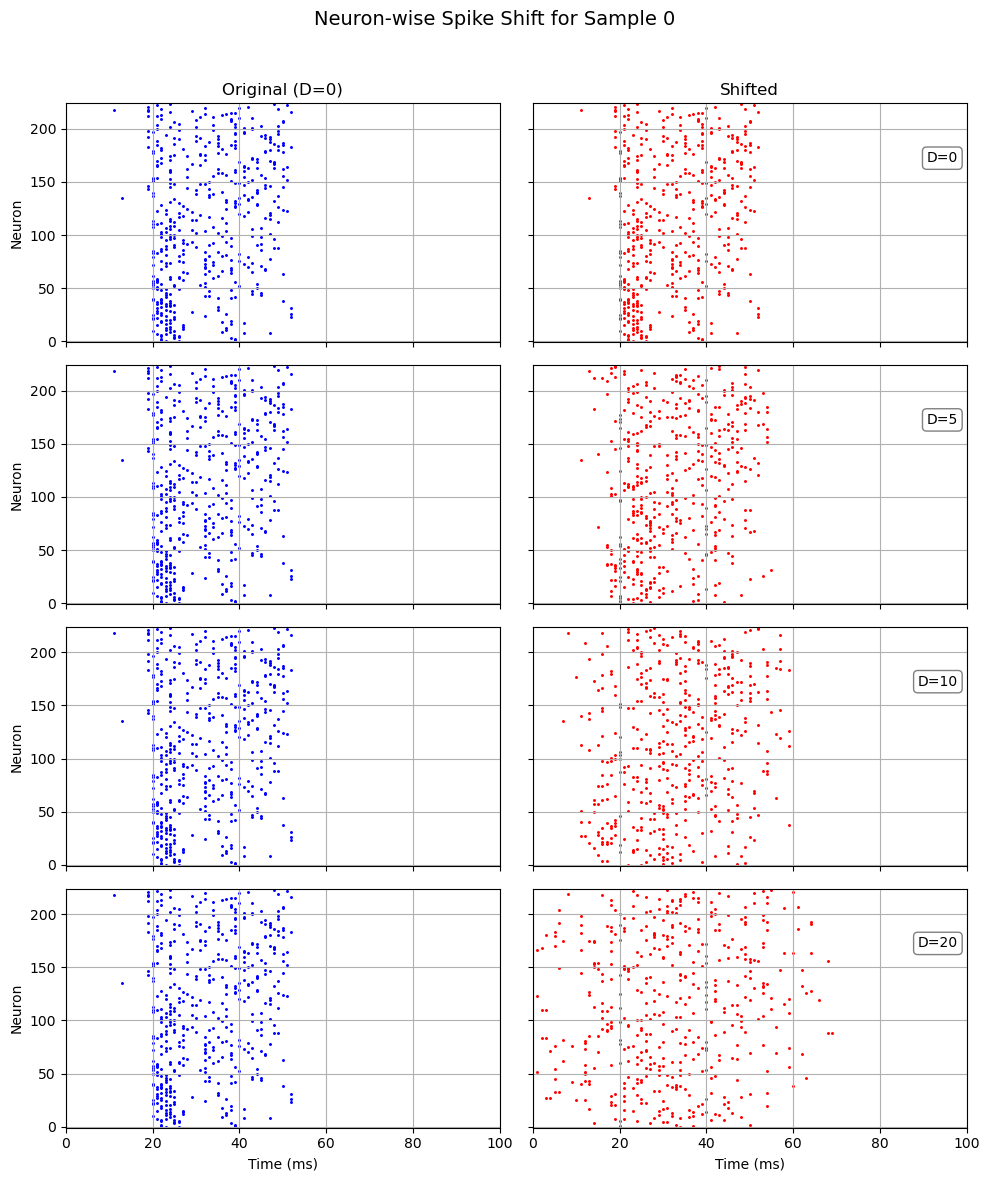

Using data index range = [0, 3276), total 3276 samples
batch_size=2
num_time_points=100
num_batches=1638
RAM usage per batch ~ 0.0003 GB
Got a batch: x_batch.shape=(2, 224, 100), y_batch=[ 4 13]


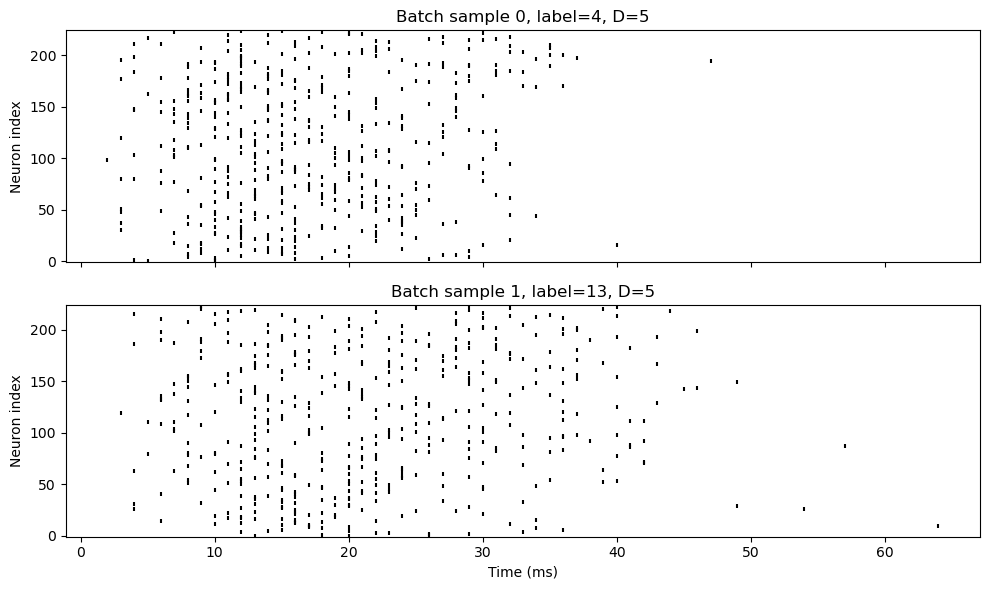

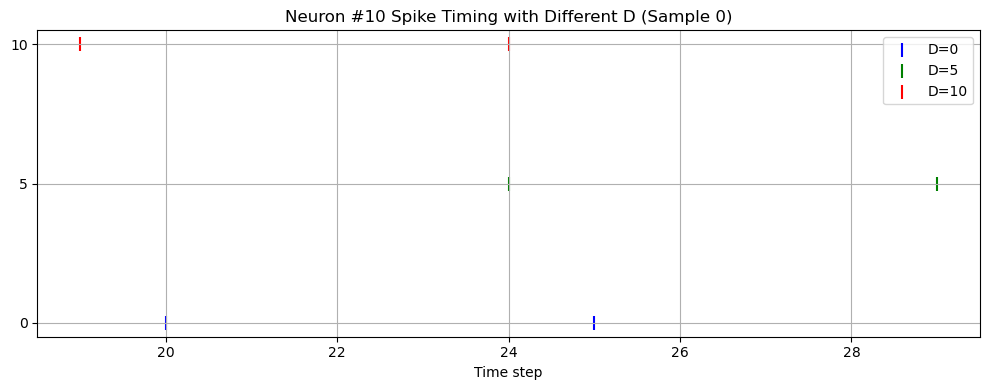

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

def spike_shift_per_neuron(spike_train, D=5):
    if D <= 0:
        return spike_train
    num_neurons, T = spike_train.shape
    new_train = np.zeros_like(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue
        d = np.random.randint(-D, D + 1)  # integer offset in [-D, D]
        shifted_times = np.clip(spike_times + d, 0, T - 1)
        shifted_times = np.unique(shifted_times)
        new_train[neuron_idx, shifted_times] = 1
    return new_train


def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, D=5,
                 verbose=False, shuffle=True, max_num_batches=None):
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx = int(round(N * f_end))
    subX = X[start_idx:end_idx]
    subY = Y[start_idx:end_idx]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b * batch_size : (b + 1) * batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_shifted = spike_shift_per_neuron(subX[sidx], D=D)
            x_batch[i] = x_shifted
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

data = loadmat("spikedata6_norm.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]

training_range = (0, 0.6)
validation_range = (0.6, 0.75)
testing_range = (0.75, 0.9)

def show_single_sample_different_D(X, Y, sample_idx=0, D_values=[0, 5, 10]):
    original_st = X[sample_idx]
    fig, axes = plt.subplots(len(D_values), 2, figsize=(10, 3 * len(D_values)), sharex=True, sharey=True)
    fig.suptitle(f"Neuron-wise Spike Shift for Sample {sample_idx}", fontsize=14)

    for row_i, D in enumerate(D_values):
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (D=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        x_shifted = spike_shift_per_neuron(original_st, D=D)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_shifted.shape[0]):
            spike_times = np.where(x_shifted[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Shifted")
        ax_right.text(0.98, 0.8, f"D={D}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def show_single_neuron_shifted_spikes(X, sample_idx=0, neuron_idx=0, D_values=[0, 5, 10]):
    spike_train = X[sample_idx]
    fig, ax = plt.subplots(figsize=(10, 4))
    colors = ['b', 'g', 'r']
    for i, D in enumerate(D_values):
        st = spike_shift_per_neuron(spike_train, D=D)
        spike_times = np.where(st[neuron_idx] == 1)[0]
        ax.scatter(spike_times, [D] * len(spike_times), label=f"D={D}", marker='|', color=colors[i % len(colors)], s=100)
    ax.set_yticks(D_values)
    ax.set_xlabel("Time step")
    ax.set_title(f"Neuron #{neuron_idx} Spike Timing with Different D (Sample {sample_idx})")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, D=5):
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, D=D, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3 * batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, D={D}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()

show_single_sample_different_D(X, Y, sample_idx=0, D_values=[0, 5, 10, 20])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, D=5)

show_single_neuron_shifted_spikes(X, sample_idx=0, neuron_idx=10, D_values=[0, 5, 10])

In [6]:
import torch
import torch.nn as nn
import numpy as np


class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 

    @staticmethod
    def forward(ctx, input):
        """
        在 forward 中做 Heaviside(step) 函数
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        surrogate gradient: d/dx of H(x) ≈ 1/(scale*|x|+1)^2
        """
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(inp) + 1.0)**2
        return grad

spike_fn = SurrGradSpike.apply

# 1) hidden Layer w1 & v1 + (syn, mem) Update
# 2) readout Layer w2 + flt, out Update
# 3) Finally return out_rec, [mem_rec, spk_rec]
class TutorialSNN(nn.Module):
    def __init__(self,nb_inputs=224,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs


In [9]:
import torch
import torch.nn.functional as F
import numpy as np

num_classes = 20

def evaluate_network(net, time_fractions, batch_size=64, D=0, device='cpu'):
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y, batch_size=batch_size, D=D, shuffle=False, max_num_batches=2)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, other_recs = net(x_t)
            m, _ = torch.max(out_rec, dim=1)
            log_probs = log_softmax_fn(m).to(device)

            loss_val = loss_fn(log_probs, y_t)
            losses.append(loss_val.item())

            zero_logits = torch.zeros_like(m)
            null_lp = log_softmax_fn(zero_logits).to(device)
            null_val = loss_fn(null_lp, y_t)
            null_losses.append(null_val.item())

    avg_loss = np.mean(losses) if len(losses) else 0.
    avg_null = np.mean(null_losses) if len(null_losses) else 0.
    return avg_loss, avg_null


def train_model(D=0, num_epochs=100, batch_size=64, max_num_batches=40,
                lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with D={D}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {dev}")

    net = TutorialSNN(num_neurons, hidden_units, num_classes).to(dev)
    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range, batch_size=batch_size, max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_losses = []

            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, D=D,
                                     shuffle=True, verbose=(epoch==0), max_num_batches=max_num_batches)

            for x_np, y_np in train_gen:
                x_t = torch.tensor(x_np, dtype=torch.float32, device=dev)
                y_t = torch.tensor(y_np, dtype=torch.long, device=dev)

                out_rec, other_recs = net(x_t)
                spk_rec = other_recs[1]

                m, _ = torch.max(out_rec, dim=1)
                log_probs = log_softmax_fn(m).to(device)

                l1_loss = 2e-6 * torch.sum(spk_rec)
                sum_per_neuron = torch.sum(spk_rec, dim=[0, 1])
                l2_loss = 2e-6 * torch.mean(sum_per_neuron ** 2)

                reg_loss = l1_loss + l2_loss
                loss_val = loss_fn(log_probs, y_t) + reg_loss
                local_losses.append(loss_val.item())

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_losses) if local_losses else 0.
            val_loss, null_val_loss = evaluate_network(net, validation_range, batch_size=64, D=D, device=dev)

            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch, train_loss=last_epoch_loss, val_loss=val_loss, null_val=null_val_loss)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net, testing_range, batch_size=64, D=D, device=dev)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss


def test_accuracy(net, time_fractions=testing_range, batch_size=64, D=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y, batch_size=batch_size, D=D, shuffle=False, max_num_batches=40)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, _ = net(x_t, dtype=x_t.dtype)
            m, _ = torch.max(out_rec, dim=1)
            preds = torch.argmax(m, dim=1).to(device)

            correct += (preds == y_t).sum().item()
            total += y_t.shape[0]

    acc = correct / total if total > 0 else 0.
    return acc



### Training model for D = 1 ###

=== Training model with D=1, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:08:13<00:00,  1.47it/s, epoch=149, null_val=3, train_loss=0.867, val_loss=2.13]


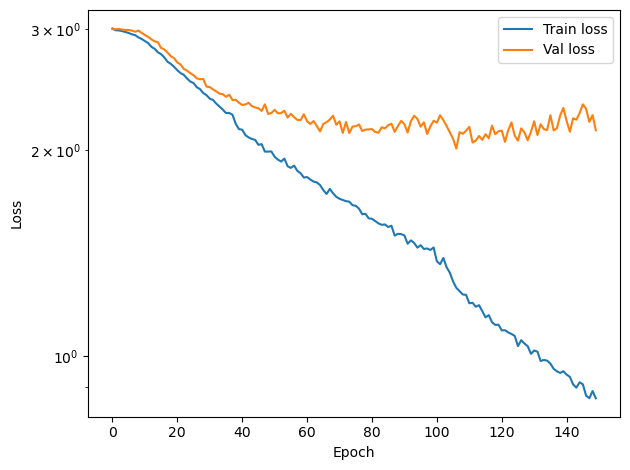

Loaded best model with val_loss=2.0081
Final Test: test_loss=2.0929, null_test_loss=2.9957
Saved model: s8_D001.pt


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
import torch

D_values = [1]

def D_to_str(D):
    return f"D{int(D):03d}"

for D in D_values:
    print(f"\n### Training model for D = {D} ###")
    net, val_loss = train_model(D=D, num_epochs=150)
    var_name = f"net_{D_to_str(D)}"
    globals()[var_name] = net

    model_path = f"s8_{D_to_str(D)}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
    print(f"D={D}, Test Accuracy: {acc:.2%}")


In [10]:
acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
print(f"D={D}, Test Accuracy: {acc:.2%}")

D=1, Test Accuracy: 36.33%



### Training model for D = 2 ###

=== Training model with D=2, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [59:30<00:00,  1.68it/s, epoch=149, null_val=3, train_loss=1.1, val_loss=2.15]  


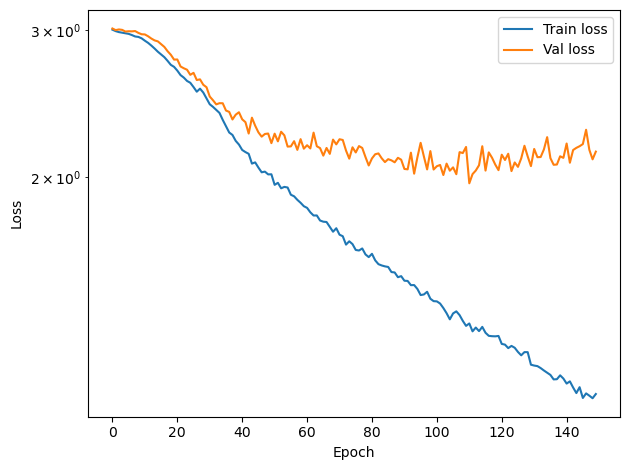

Loaded best model with val_loss=1.9663
Final Test: test_loss=1.9424, null_test_loss=2.9957
Saved model: s8_D002.pt
D=2, Test Accuracy: 34.24%

### Training model for D = 5 ###

=== Training model with D=5, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [56:16<00:00,  1.78it/s, epoch=149, null_val=3, train_loss=1.51, val_loss=1.96] 


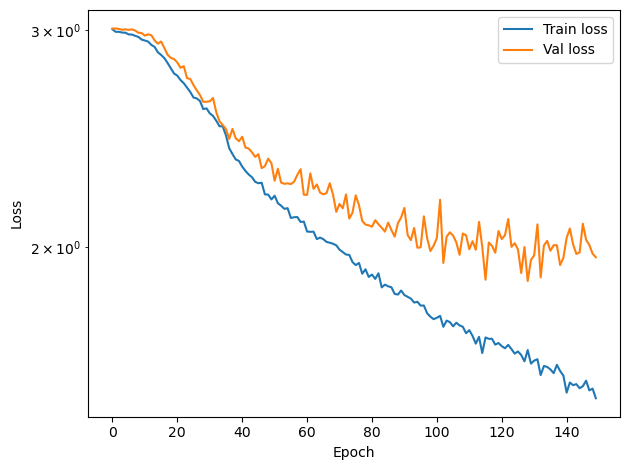

Loaded best model with val_loss=1.8768
Final Test: test_loss=1.9495, null_test_loss=2.9957
Saved model: s8_D005.pt
D=5, Test Accuracy: 34.64%

### Training model for D = 10 ###

=== Training model with D=10, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:07:11<00:00,  1.49it/s, epoch=149, null_val=3, train_loss=2.12, val_loss=2.18]


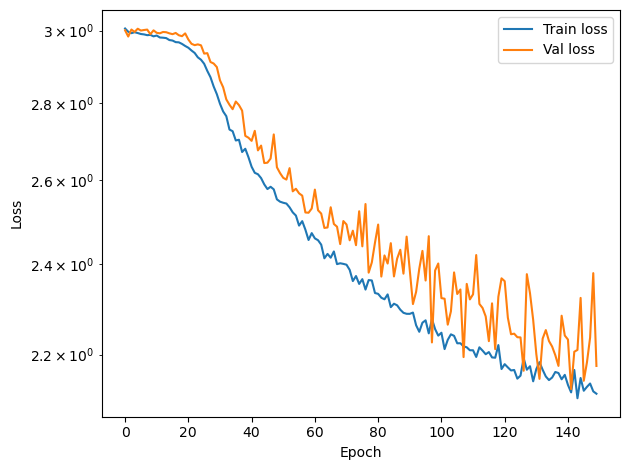

Loaded best model with val_loss=2.1285
Final Test: test_loss=2.1143, null_test_loss=2.9957
Saved model: s8_D010.pt
D=10, Test Accuracy: 27.21%


In [ ]:
D_values = [2, 5, 10]

def D_to_str(D):
    return f"D{int(D):03d}"

for D in D_values:
    print(f"\n### Training model for D = {D} ###")
    net, val_loss = train_model(D=D, num_epochs=150)
    var_name = f"net_{D_to_str(D)}"
    globals()[var_name] = net

    model_path = f"s8_{D_to_str(D)}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
    print(f"D={D}, Test Accuracy: {acc:.2%}")


### Training model for D = 15 ###

=== Training model with D=15, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:02:58<00:00,  1.59it/s, epoch=149, null_val=3, train_loss=2.46, val_loss=2.53]


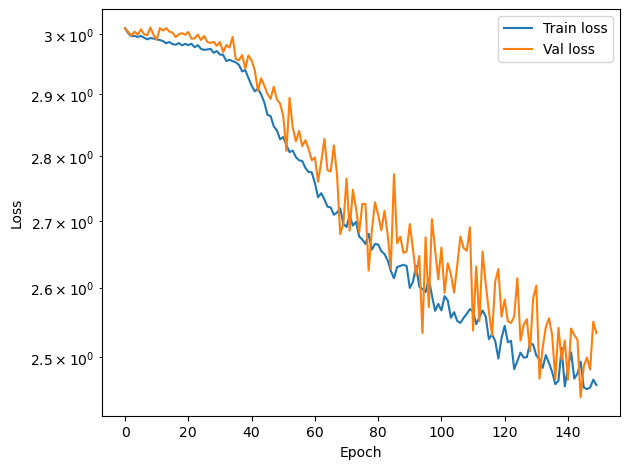

Loaded best model with val_loss=2.4438
Final Test: test_loss=2.3492, null_test_loss=2.9957
Saved model: s8_D015.pt
D=15, Test Accuracy: 20.05%


In [ ]:
D_values = [15]

def D_to_str(D):
    return f"D{int(D):03d}"

for D in D_values:
    print(f"\n### Training model for D = {D} ###")
    net, val_loss = train_model(D=D, num_epochs=150)
    var_name = f"net_{D_to_str(D)}"
    globals()[var_name] = net

    model_path = f"s8_{D_to_str(D)}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
    print(f"D={D}, Test Accuracy: {acc:.2%}")


### Training model for D = 20 ###

=== Training model with D=20, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:06:59<00:00,  1.49it/s, epoch=149, null_val=3, train_loss=2.82, val_loss=2.86]


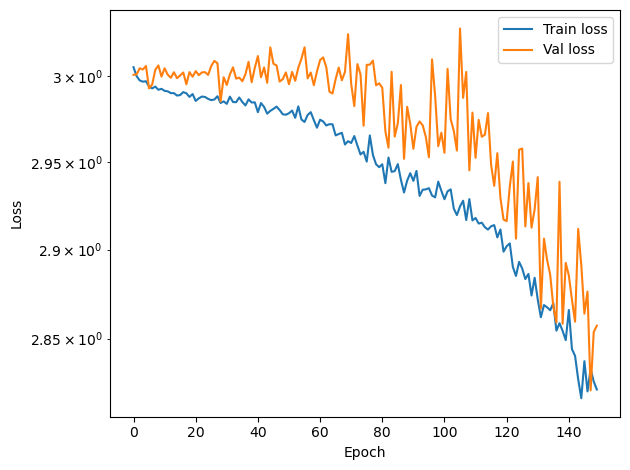

Loaded best model with val_loss=2.8213
Final Test: test_loss=2.8126, null_test_loss=2.9957
Saved model: s8_D020.pt
D=20, Test Accuracy: 14.97%


In [ ]:
D_values = [20]

def D_to_str(D):
    return f"D{int(D):03d}"

for D in D_values:
    print(f"\n### Training model for D = {D} ###")
    
    net, val_loss = train_model(D=D, num_epochs=150)
    var_name = f"net_{D_to_str(D)}"
    globals()[var_name] = net

    model_path = f"s8_{D_to_str(D)}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
    print(f"D={D}, Test Accuracy: {acc:.2%}")


### Training model for D = 25 ###

=== Training model with D=25, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:00:26<00:00,  1.65it/s, epoch=149, null_val=3, train_loss=2.85, val_loss=2.88]


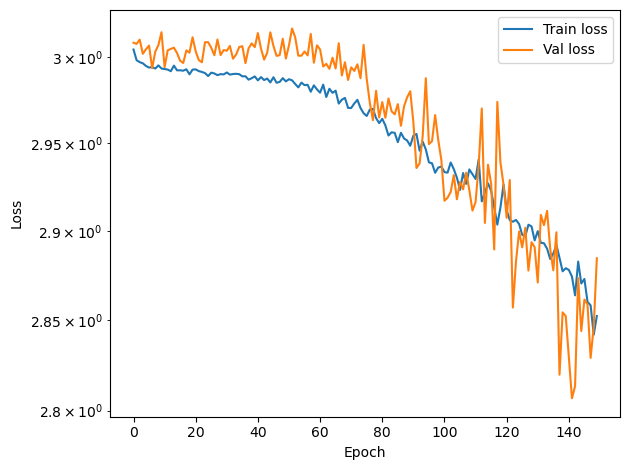

Loaded best model with val_loss=2.8068
Final Test: test_loss=2.8276, null_test_loss=2.9957
Saved model: s8_D025.pt
D=25, Test Accuracy: 9.77%


In [ ]:
D_values = [25]

def D_to_str(D):
    return f"D{int(D):03d}"

for D in D_values:
    print(f"\n### Training model for D = {D} ###")
    net, val_loss = train_model(D=D, num_epochs=150)
    var_name = f"net_{D_to_str(D)}"
    globals()[var_name] = net

    model_path = f"s8_{D_to_str(D)}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, time_fractions=testing_range, batch_size=128, D=D, device='cuda')
    print(f"D={D}, Test Accuracy: {acc:.2%}")


=== Loading model s8_D000.pt and testing (D=0) ===
D=0, Mean Acc=37.63%, Std=0.00% (over 5 runs)

=== Loading model s8_D002.pt and testing (D=2) ===
D=2, Mean Acc=35.94%, Std=1.39% (over 5 runs)

=== Loading model s8_D005.pt and testing (D=5) ===
D=5, Mean Acc=33.26%, Std=1.15% (over 5 runs)

=== Loading model s8_D010.pt and testing (D=10) ===
D=10, Mean Acc=26.48%, Std=2.10% (over 5 runs)

=== Loading model s8_D015.pt and testing (D=15) ===
D=15, Mean Acc=20.03%, Std=0.55% (over 5 runs)

=== Loading model s8_D020.pt and testing (D=20) ===
D=20, Mean Acc=12.86%, Std=0.57% (over 5 runs)

=== Loading model s8_D025.pt and testing (D=25) ===
D=25, Mean Acc=11.17%, Std=0.88% (over 5 runs)


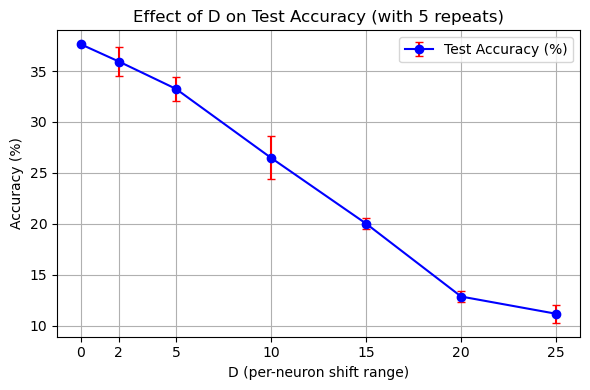

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io


D_values = [0, 2, 5, 10, 15, 20, 25]
repeats = 5

def D_to_str(D):
    return f"D{int(D):03d}"

def test_accuracy_repeats(net, repeats=5, D=0):
    acc_list = []
    for r in range(repeats):
        acc = test_accuracy(
            net,
            time_fractions=testing_range,
            batch_size=256,
            D=D,
            device=device
        )
        acc_list.append(acc)
    return acc_list


all_means = []
all_stds = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for D in D_values:
    model_path = f"s8_{D_to_str(D)}.pt"
    print(f"\n=== Loading model {model_path} and testing (D={D}) ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    acc_list = test_accuracy_repeats(net, repeats=repeats, D=D)
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"D={D}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")

plt.figure(figsize=(6, 4))

means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

plt.errorbar(D_values, means_pct, yerr=stds_pct,
             fmt='-o', color='blue', ecolor='red', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("D (per-neuron shift range)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of D on Test Accuracy (with {repeats} repeats)")
plt.xticks(D_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
